In [1]:
from lib.text_exploration.doc_explorer import DocExplorer
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from nltk.corpus import reuters
from matplotlib import pyplot as plt
%matplotlib inline  

In [2]:
selected_categories = ['housing', 'gas', 'tea', 'lumber', 'jobs', 'retail']
texts = []
for c in selected_categories:
    for file in reuters.fileids(c):
        texts.append(reuters.raw(file))

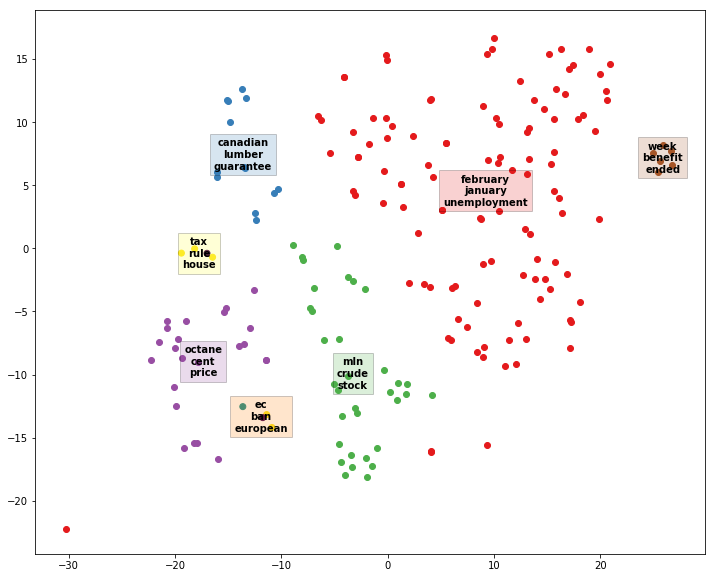

In [3]:
plt.figure(figsize=(12,10))
doc_explorer = DocExplorer(embedding=TSNE(perplexity=20, early_exaggeration=30), clustering=DBSCAN(eps=4, min_samples=4))
doc_explorer.fit(texts)
doc_explorer.plot_static()